# Deep Learning NLP - Labs
Text Clustering with K-Means and SBERT Sentence Embeddings using Autoencoders

<br>


#### Dataset
@dataset {consolidated_climate_dataset,  
    author = {Joseph Pollack},  
    title = {Climate Guard Toxic Agent - Dataset},  
    year = {2024},  
    publisher = {Hugging Face},  
    url = { https://huggingface.co/datasets/Tonic/Climate-Guard-Toxic-Agent }  
}
<br>

<br>
@Ricardo Almeida

In [1]:
# Install Sentence-Transformers for Sentence-BERT
!pip install sentence-transformers

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

/opt/anaconda3/envs/ml/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [4]:
text_column = 'text'

### Loading dataset

In [5]:
df = pd.read_parquet("data/climate_text_sample.parquet")

df = df[[text_column]]
df = df.copy()

In [6]:
# Step 2: Load Sentence-BERT Model
# Load a small-sized SBERT model from Sentence-Transformers library
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')  # Example of a small SBERT model

In [7]:
# Step 3: Compute Document Embeddings with SBERT
def get_sentence_embedding(text, model):
    return model.encode(text)  # Get sentence-level embedding

# Generate embeddings for each document in 'text_column'
df['embedding'] = df[text_column].apply(lambda x: get_sentence_embedding(x, sbert_model))
embeddings = np.vstack(df['embedding'].values)  # Stack into a 2D array for further processing

In [8]:
# Step 4: Define and Train Autoencoder for Dimensionality Reduction
input_dim = embeddings.shape[1]
encoding_dim = 2  # Compress to 2D for visualization

# Build Autoencoder Model using the Functional API
input_layer = Input(shape=(input_dim,))

# Encoder
x = Dense(128, activation='relu')(input_layer)
x = Dense(256, activation='relu')(x)
bottleneck = Dense(encoding_dim, activation='relu', name='bottleneck')(x)  # Bottleneck layer for 2D embedding

# Decoder
x = Dense(128, activation='relu')(bottleneck)
output_layer = Dense(input_dim, activation='linear')(x)

# Full Autoencoder
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Compile Autoencoder
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [9]:
# Step 5: Train Autoencoder
autoencoder.fit(embeddings, embeddings, epochs=10, batch_size=16, verbose=1)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - loss: 0.0018
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 0.0011
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 0.0010  
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - loss: 9.8775e-04
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 9.8955e-04
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 9.6532e-04
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 9.6338e-04
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 9.5709e-04
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 9.5607e-04


In [10]:
# Step 6: Extract 2D Embeddings from Bottleneck Layer
encoder = Model(inputs=input_layer, outputs=bottleneck)
reduced_embeddings_autoencoder = encoder.predict(embeddings)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step


In [11]:
# Step 6: Perform K-Means Clustering on Reduced Embeddings
# Using K-Means to detect clusters of semantically similar content
kmeans = KMeans(n_clusters=3, n_init='auto', random_state=42)  # Assume 3 clusters for example
labels = kmeans.fit_predict(reduced_embeddings_autoencoder)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [12]:
# Step 7: Assign Clusters to the DataFrame
df['cluster'] = labels

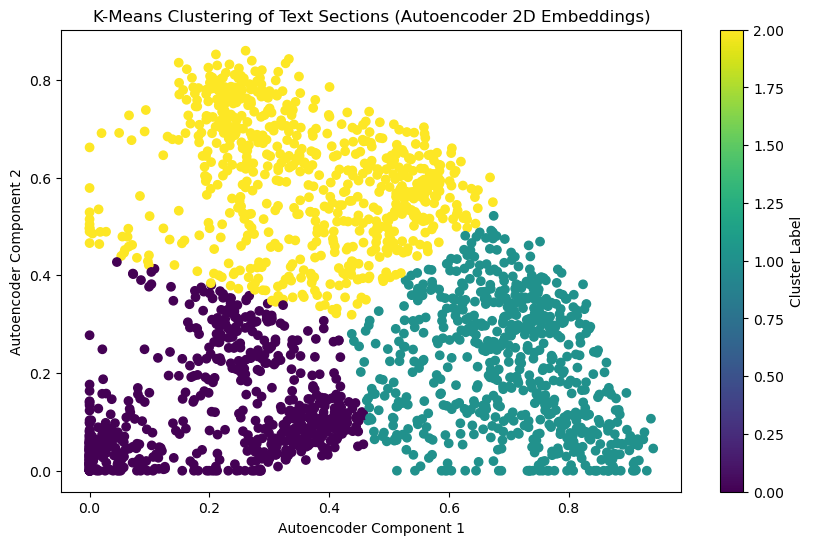

In [13]:
# Step 8: Visualize Clusters with Autoencoder Embeddings
# Plot the 2D embeddings and color by cluster
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_embeddings_autoencoder[:, 0], reduced_embeddings_autoencoder[:, 1], c=labels, cmap='viridis')
plt.colorbar(label="Cluster Label")
plt.title("K-Means Clustering of Text Sections (Autoencoder 2D Embeddings)")
plt.xlabel("Autoencoder Component 1")
plt.ylabel("Autoencoder Component 2")
plt.show()

In [14]:
# Step 9: Split the DataFrame into K Groups (Based on Cluster Labels)
# Split into K groups based on the unique cluster labels from K-Means
clustered_groups = [df[df['cluster'] == k] for k in set(labels)]

# Show a summary of clusters
for idx, group in enumerate(clustered_groups):
    print(f"\nCluster {idx} - Number of sections: {len(group)}")
    print(group[text_column].head(3))  # Print first 3 sections in each cluster


Cluster 0 - Number of sections: 676
0    Since 1938, New England has experienced no hur...
1    Climate action initiatives often come with sig...
4    Since 2010, global energy consumption has been...
Name: text, dtype: object

Cluster 1 - Number of sections: 641
2     Between 1972 and 2023, the Amazon rainforest l...
3     In recent years, climate science has been mark...
12    The Earth's carbon cycle is a critical compone...
Name: text, dtype: object

Cluster 2 - Number of sections: 683
8     Global warming is a misinterpretation of natur...
9     Greenhouse gases are constantly being cycled t...
16    In recent decades, there have been persistent ...
Name: text, dtype: object


Cluster 0 Keywords: economic, fossil, fuels, energy, policies, social, growth, environmental, living, global
Cluster 1 Keywords: science, scientific, scientists, global, uncertainties, data, models, environmental, warming, significant
Cluster 2 Keywords: natural, human, global, warming, variability, weather, changes, activities, significant, patterns


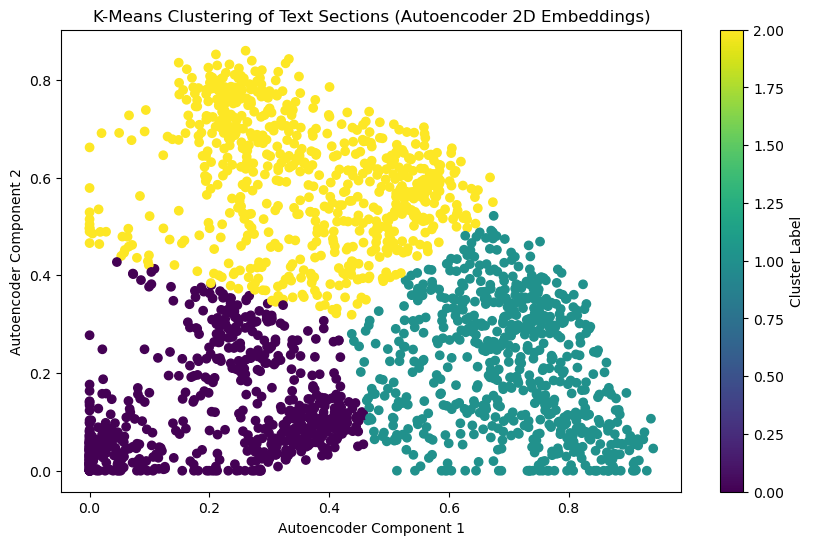


Cluster 0 - Number of sections: 676
0    Since 1938, New England has experienced no hur...
1    Climate action initiatives often come with sig...
4    Since 2010, global energy consumption has been...
Name: text, dtype: object

Cluster 1 - Number of sections: 641
2     Between 1972 and 2023, the Amazon rainforest l...
3     In recent years, climate science has been mark...
12    The Earth's carbon cycle is a critical compone...
Name: text, dtype: object

Cluster 2 - Number of sections: 683
8     Global warming is a misinterpretation of natur...
9     Greenhouse gases are constantly being cycled t...
16    In recent decades, there have been persistent ...
Name: text, dtype: object


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the blacklist of words you want to exclude from the analysis
blacklist = {'climate', 'change'}

# Combine blacklist with the default English stop words
tfidf_vectorizer = TfidfVectorizer(stop_words='english')  # Initialize with English stop words
all_stop_words = list(set(tfidf_vectorizer.get_stop_words()).union(blacklist))  # Combine with blacklist

# Reinitialize the TfidfVectorizer with the combined stop words
tfidf_vectorizer = TfidfVectorizer(stop_words=all_stop_words)

# Store the top N keywords for each cluster
top_n_keywords = 10  # Number of top keywords to extract per cluster
cluster_keywords = {}

# Loop through each cluster and extract the top N keywords using TF-IDF
for cluster_num in range(kmeans.n_clusters):
    cluster_docs = df[df['cluster'] == cluster_num][text_column]
    
    # Fit the TF-IDF model on the documents of the cluster
    tfidf_matrix = tfidf_vectorizer.fit_transform(cluster_docs)
    
    # Get feature names (words)
    feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
    
    # Sum TF-IDF scores across all documents in the cluster
    tfidf_scores = np.asarray(tfidf_matrix.sum(axis=0)).flatten()
    
    # Get indices of top N keywords based on TF-IDF scores
    top_indices = np.argsort(tfidf_scores)[::-1][:top_n_keywords]
    
    # Get the top N keywords
    top_keywords = feature_names[top_indices]
    
    # Store the keywords for the cluster
    cluster_keywords[cluster_num] = top_keywords

# Step 10: Display Cluster Keywords
for cluster_num, keywords in cluster_keywords.items():
    print(f"Cluster {cluster_num} Keywords: {', '.join(keywords)}")

# Step 11: Visualize Clusters with Autoencoder Embeddings
# Plot the 2D embeddings and color by cluster
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_embeddings_autoencoder[:, 0], reduced_embeddings_autoencoder[:, 1], c=labels, cmap='viridis')
plt.colorbar(label="Cluster Label")
plt.title("K-Means Clustering of Text Sections (Autoencoder 2D Embeddings)")
plt.xlabel("Autoencoder Component 1")
plt.ylabel("Autoencoder Component 2")
plt.show()

# Step 12: Split the DataFrame into K Groups (Based on Cluster Labels)
# Split into K groups based on the unique cluster labels from K-Means
clustered_groups = [df[df['cluster'] == k] for k in set(labels)]

# Show a summary of clusters
for idx, group in enumerate(clustered_groups):
    print(f"\nCluster {idx} - Number of sections: {len(group)}")
    print(group[text_column].head(3))